In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import tqdm
import tensorflow as tf
sns.set(font_scale=1.5, style='darkgrid')

# Import Data

We use the Cleveland heart disease dataset

**Context**

This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by ML researchers to 
this date. The "goal" field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4.

**Content**


*Attribute Information:*
  * age 
  * sex 
  * chest pain type (4 values) 
  * resting blood pressure 
  * serum cholestoral in mg/dl 
  * fasting blood sugar > 120 mg/dl
  * resting electrocardiographic results (values 0,1,2)
  * maximum heart rate achieved 
  * exercise induced angina 
  * oldpeak = ST depression induced by exercise relative to rest 
  * the slope of the peak exercise ST segment 
  * number of major vessels (0-3) colored by flourosopy 
  * thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

**Acknowledgements**

*Creators:*

Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.
Donor: 
David W. Aha (aha '@' ics.uci.edu) (714) 856-8779

We import the data using kaggle. You can also find the dataset in the UCI repository.

In [2]:
import kaggle
kaggle.api.authenticate()

kaggle.api.dataset_download_files(
    'cherngs/heart-disease-cleveland-uci',
    path='./data',
    quiet=False,
    unzip=True,
    force=False,
)

100%|██████████| 3.33k/3.33k [00:00<00:00, 5.72kB/s]

In [20]:
data = pd.read_csv('./data/heart_cleveland_upload.csv')

In [21]:
data.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0
5,64,1,0,170,227,0,2,155,0,0.6,1,0,2,0
6,63,1,0,145,233,1,2,150,0,2.3,2,0,1,0
7,61,1,0,134,234,0,0,145,0,2.6,1,2,0,1
8,60,0,0,150,240,0,0,171,0,0.9,0,0,0,0
9,59,1,0,178,270,0,2,145,0,4.2,2,0,2,0


There are some columns containing multi-category data. In this case, 

In [22]:
data = pd.get_dummies(data, columns=['cp', 'restecg', 'slope', 'ca', 'thal'])

In [23]:
data

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,condition,cp_0,...,slope_0,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,thal_0,thal_1,thal_2
0,69,1,160,234,1,131,0,0.1,0,1,...,0,1,0,0,1,0,0,1,0,0
1,69,0,140,239,0,151,0,1.8,0,1,...,1,0,0,0,0,1,0,1,0,0
2,66,0,150,226,0,114,0,2.6,0,1,...,0,0,1,1,0,0,0,1,0,0
3,65,1,138,282,1,174,0,1.4,1,1,...,0,1,0,0,1,0,0,1,0,0
4,64,1,110,211,0,144,1,1.8,0,1,...,0,1,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,40,1,152,223,0,181,0,0.0,1,0,...,1,0,0,1,0,0,0,0,0,1
293,39,1,118,219,0,140,0,1.2,1,0,...,0,1,0,1,0,0,0,0,0,1
294,35,1,120,198,0,130,1,1.6,1,0,...,0,1,0,1,0,0,0,0,0,1
295,35,0,138,183,0,182,0,1.4,0,0,...,1,0,0,1,0,0,0,1,0,0


Scale data and do a train-validation-test split

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [25]:
y = data.pop('condition').values
x = data.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=123)

Remember, only fit the scaler on the training set so that no information about the test set enters the training process at all

In [26]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Baseline Model

We will write some simple functions to build models, train models and evaluate models. This is so that we can avoid writing repeat code, as much as possible.

In [27]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tqdm.keras import TqdmCallback

In [32]:
def build_model(**layer_kwargs):
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(25, ), **layer_kwargs))
    model.add(Dense(128, activation='relu', **layer_kwargs))
    model.add(Dense(1, activation='sigmoid', **layer_kwargs))
    return model

def train_and_save(model, path, force=True, **kwargs):
    """
    Looks for saved model in path, if found, load.
    If not, compile, train and save model to path
    If force=True, will always retrain
    """
    model_save_dir = pathlib.Path(path)
    model_save_dir.mkdir(parents=True, exist_ok=True)
    model_path = model_save_dir.joinpath('model.h5')
    history_path = model_save_dir.joinpath('history.json')
    
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['binary_accuracy'],
    )

    if model_path.exists() and history_path.exists() and not force:
        model.load_weights(str(model_path))
        history = pd.read_json(history_path)
    else:
        batch_size = kwargs.get('batch_size', 128)
        callbacks = kwargs.get('callbacks', [TqdmCallback(verbose=0)])
        epochs = kwargs.get('epochs', 500)
        validation_data = kwargs.get('validation_data', (x_test, y_test))
        validation_split = kwargs.get('validation_split', 0)
        history = model.fit(
            x=x_train,
            y=y_train,
            batch_size=batch_size,
            validation_data=validation_data,
            validation_split=validation_split,
            verbose=0,
            epochs=epochs,
            callbacks=callbacks,
        )
        model.save_weights(str(model_path))
        history = pd.DataFrame(history.history)
        history.to_json(history_path)
    return history

def evaluate(model, train_data, test_data):
    """
    Evaluate model on train/test sets
    """
    eval_train = model.evaluate(*train_data, verbose=0)
    eval_test = model.evaluate(*test_data, verbose=0)
    print(f'Train - loss = {eval_train[0]:.3f}, acc = {eval_train[1]:.3f} ')
    print(f'Test - loss = {eval_test[0]:.3f}, acc = {eval_test[1]:.3f} ')

In [33]:
model = build_model()

In [34]:
history = train_and_save(model=model, path='baseline')

0epoch [00:00, ?epoch/s]

Train - loss = 0.000, acc = 1.000 
Test - loss = 1.896, acc = 0.811 


<AxesSubplot: >

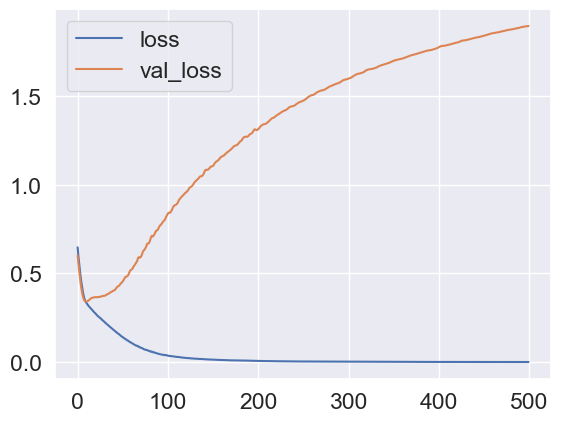

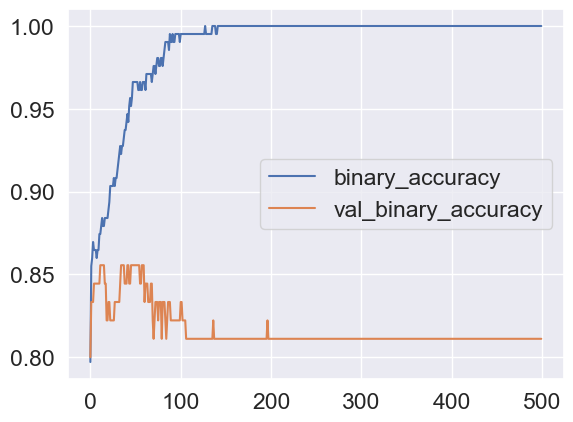

In [35]:
evaluate(model=model, train_data=(x_train, y_train), test_data=(x_test, y_test))
history.plot(x=None, y=['loss', 'val_loss'])
history.plot(x=None, y=['binary_accuracy', 'val_binary_accuracy'])

# Parameter Norm Penalties

## $L^2$ Regularized Model

In [36]:
from tensorflow.keras.regularizers import l2

In [37]:
alpha = 0.01
model = build_model(kernel_regularizer=l2(alpha))

In [38]:
history = train_and_save(model=model, path='l2_regularized')

0epoch [00:00, ?epoch/s]

Train - loss = 0.369, acc = 0.928 
Test - loss = 0.518, acc = 0.878 


<AxesSubplot: >

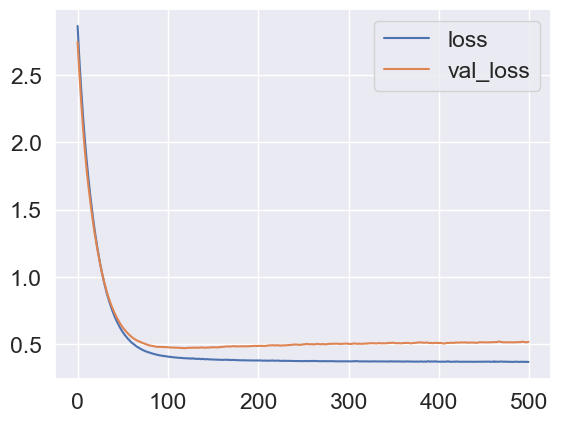

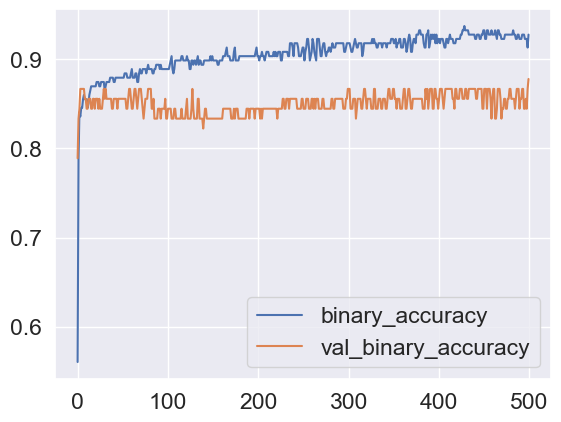

In [39]:
evaluate(model=model, train_data=(x_train, y_train), test_data=(x_test, y_test))
history.plot(x=None, y=['loss', 'val_loss'])
history.plot(x=None, y=['binary_accuracy', 'val_binary_accuracy'])

## $L^1$ Regularized Model

In [40]:
from tensorflow.keras.regularizers import l1

In [41]:
alpha = 0.001
model = build_model(kernel_regularizer=l1(alpha))

In [42]:
history = train_and_save(model=model, path='l1_regularized', force=True)

0epoch [00:00, ?epoch/s]

Train - loss = 0.240, acc = 0.966 
Test - loss = 0.745, acc = 0.833 


<AxesSubplot: >

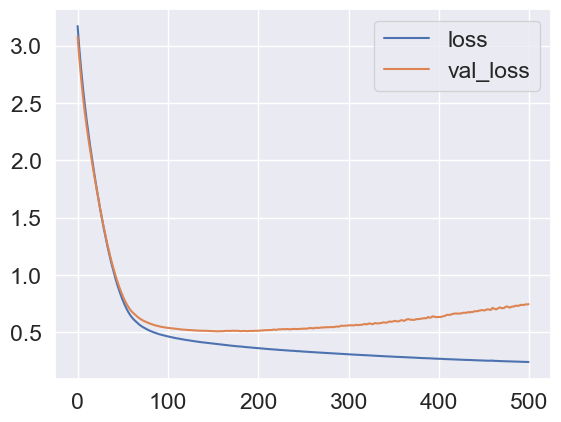

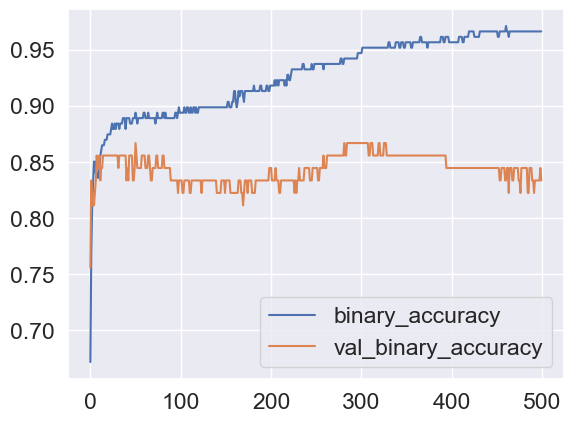

In [43]:
evaluate(model=model, train_data=(x_train, y_train), test_data=(x_test, y_test))
history.plot(x=None, y=['loss', 'val_loss'])
history.plot(x=None, y=['binary_accuracy', 'val_binary_accuracy'])

### Sparsity

In [44]:
def plot_kernel_dist(model, path):
    _ = train_and_save(model=model, path=path, force=False)

    kernel_abs_values = np.concatenate(
        [
            np.abs(w.numpy().ravel()) for w in model.weights if 'kernel' in w.name
        ]
    )

    ax = sns.histplot(kernel_abs_values, bins=50)
    ax.set(yscale='log')
    ax.set_xlabel('Weight Abs Value')
    ax.set_ylabel('Frequency')
    ax.set_title(path)
    
    return kernel_abs_values

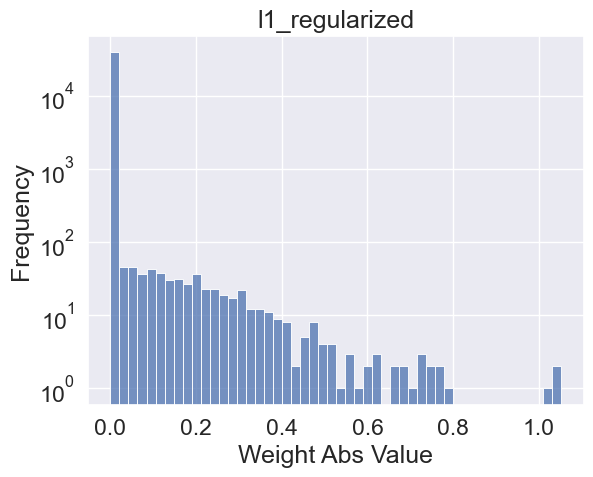

In [45]:
aa = plot_kernel_dist(model, 'l1_regularized')

Compare with the $L^2$ case

array([0.00343942, 0.00069275, 0.06427035, ..., 0.1653028 , 0.25906467,
       0.33798996], dtype=float32)

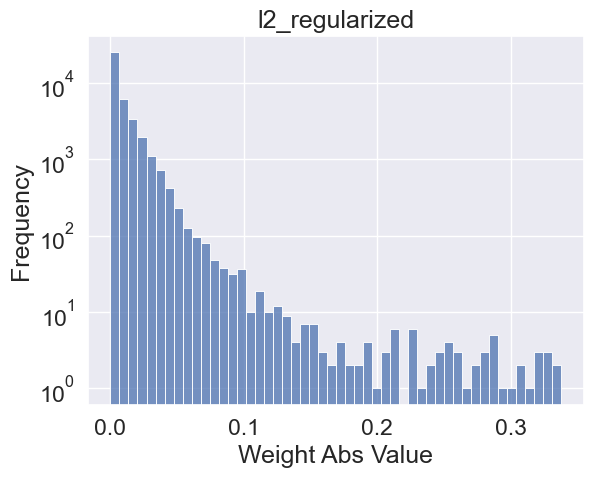

In [46]:
plot_kernel_dist(model, 'l2_regularized')

Compare with baseline

array([0.06602115, 0.03284344, 0.02805309, ..., 0.17048241, 0.14038768,
       0.05104317], dtype=float32)

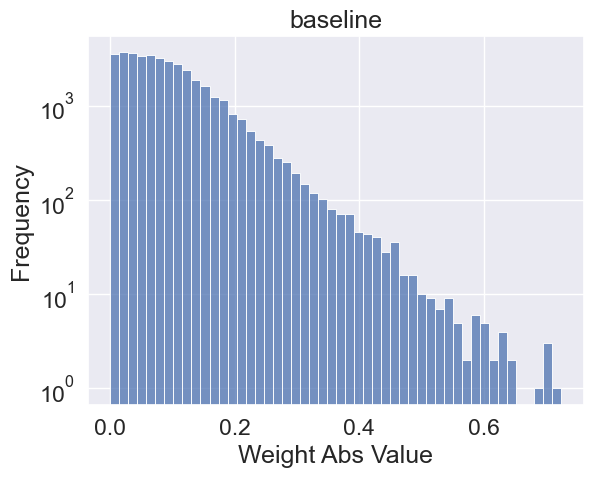

In [47]:
plot_kernel_dist(model, 'baseline')

# Early Stopping

Here we will implement the early stopping method. This is supported in keras via the `EarlyStopping` callback. 

In [48]:
from tensorflow.keras.callbacks import EarlyStopping

In [49]:
early_stopper = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
)

In [50]:
model = build_model()

Here, we need to be careful about how to perform early stopping. First, we will define a validation set to use for early stopping.

In [51]:
history = train_and_save(
    model=model,
    path='early_stopping',
    callbacks=[TqdmCallback(verbose=0), early_stopper],
    validation_data=None,
    validation_split=0.1,
)

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

Epoch 19: early stopping


Now, we retrain on the whole training set with the number of epochs equal to the stopping point.

In [52]:
model = build_model()

In [53]:
history = train_and_save(
    model=model,
    path='early_stopping',
    callbacks=[TqdmCallback(verbose=0)],
    epochs=len(history),
)

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

Train - loss = 0.280, acc = 0.884 
Test - loss = 0.364, acc = 0.822 


<AxesSubplot: >

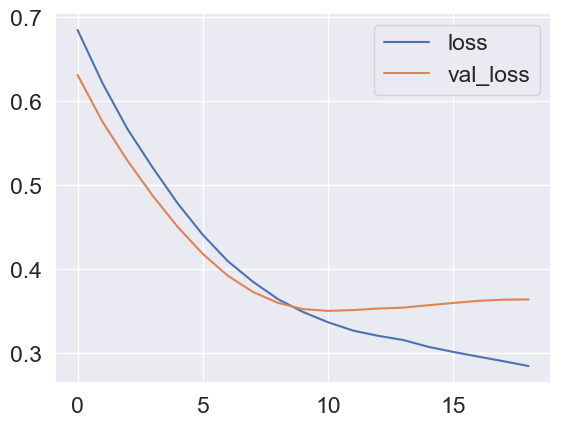

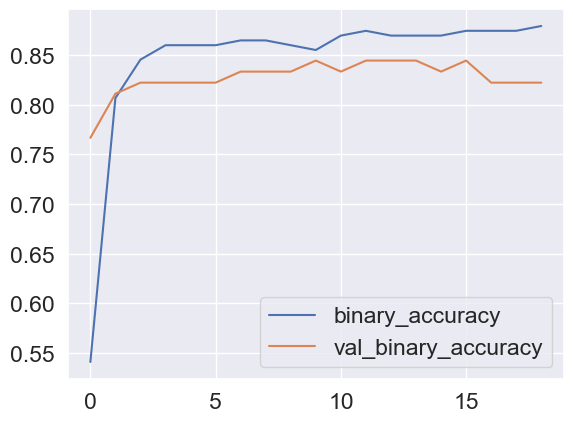

In [54]:
evaluate(model=model, train_data=(x_train, y_train), test_data=(x_test, y_test))
history.plot(x=None, y=['loss', 'val_loss'])
history.plot(x=None, y=['binary_accuracy', 'val_binary_accuracy'])

# Adding Noise

Now, we consider adding noise to the inputs and features using the `GaussianNoise` layer, which adds i.i.d. Gaussian noise to each input/hidden features.

In [55]:
from tensorflow.keras.layers import GaussianNoise

In [59]:
model = Sequential()
model.add(GaussianNoise(0.5, input_shape=(25, )))
model.add(Dense(256, activation='relu'))
model.add(GaussianNoise(0.5))
model.add(Dense(128, activation='relu'))
model.add(GaussianNoise(0.5))
model.add(Dense(1, activation='sigmoid'))

In [60]:
history = train_and_save(model=model, path='adding_noise')

0epoch [00:00, ?epoch/s]

Train - loss = 0.297, acc = 0.879 
Test - loss = 0.364, acc = 0.856 


<AxesSubplot: >

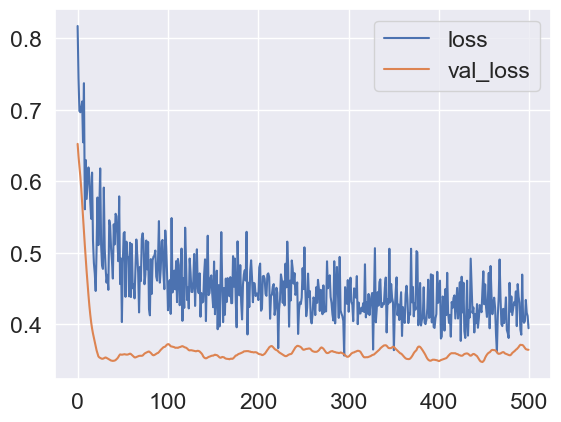

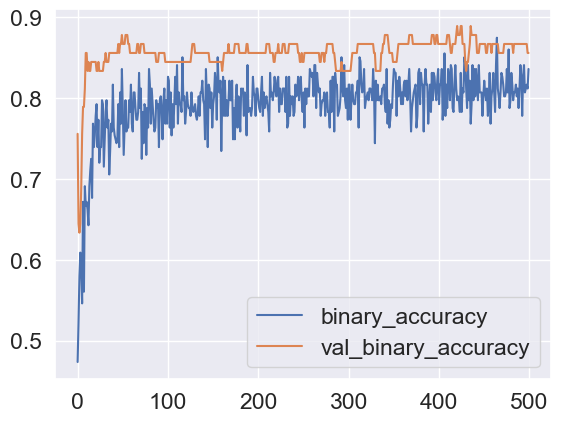

In [61]:
evaluate(model=model, train_data=(x_train, y_train), test_data=(x_test, y_test))
history.plot(x=None, y=['loss', 'val_loss'])
history.plot(x=None, y=['binary_accuracy', 'val_binary_accuracy'])

# Dropout

We will implement the efficient model-ensembling technique called dropout. This can be easily done using the pre-defined `Dropout` layer in `keras`. 

In [62]:
from tensorflow.keras.layers import Dropout

In [65]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(25, )))
model.add(Dropout(rate=0.95))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.95))
model.add(Dense(1, activation='sigmoid'))

Here we will use a rather large dropout rate because of data scarcity. Usually a rate of 0.4-0.6 are used. 

In [66]:
history = train_and_save(model=model, path='dropout')

0epoch [00:00, ?epoch/s]

Train - loss = 0.295, acc = 0.894 
Test - loss = 0.361, acc = 0.844 


<AxesSubplot: >

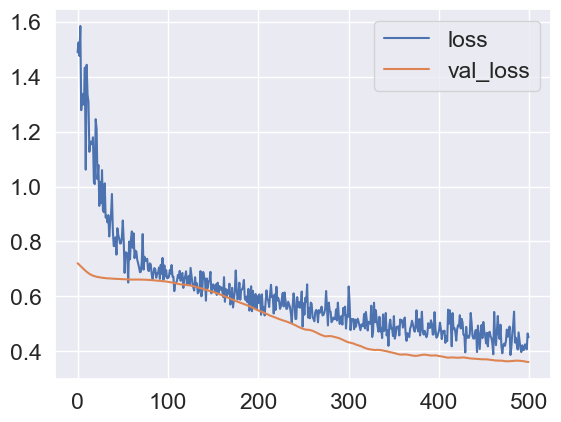

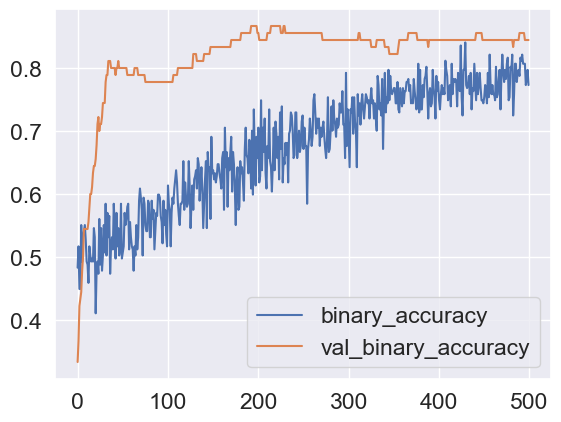

In [67]:
evaluate(model=model, train_data=(x_train, y_train), test_data=(x_test, y_test))
history.plot(x=None, y=['loss', 'val_loss'])
history.plot(x=None, y=['binary_accuracy', 'val_binary_accuracy'])

# Exercises

1. Combine the different techniques above to further improve performance.
2. Explore how the hyper-parameters, such as regularization strengths, patience parameters or dropout rates affect the performance.